# ESTIMATION OF ANNUAL INSURANCE CHARGES

#PROBLEM STATEMENT

> ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States.**I need to create an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits and region of residence. 



# 1. DATA ACQUISITION

# **Dataset source**
[Data Set](https://github.com/stedy/Machine-Learning-with-R-datasets)

In [1]:
import pandas as pd

In [2]:
data =  pd.read_csv('medical.csv')
medical_df = data.copy()

In [3]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns.

In [4]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values.

## Here are some statistics for the numerical columns:

In [5]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The ranges of values in the numerical columns seem reasonable too (no negative ages!). The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.




# 2. DATA EXPLORATION

In [6]:
# !pip install plotly matplotlib seaborn --quiet

In [7]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following settings will improve the default style and font sizes for our charts.

In [8]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. 

In [9]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [10]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.




### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [11]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['green'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)



### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [12]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['red', 'green'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \$7300, the median for smokers is close to \$35,000.


### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [13]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [14]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke. We can also see that smoking appears a more common habit among males



# Visualizing the relationship between **"charges"** and other columns.

## Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. Use values in the "smoker" column to color the points.

In [15]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Use the values from the "smoker" column to color the points.

In [16]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.


## Correlation

- As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

- Let see the correlation between each feature.

In [17]:
medical_df.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


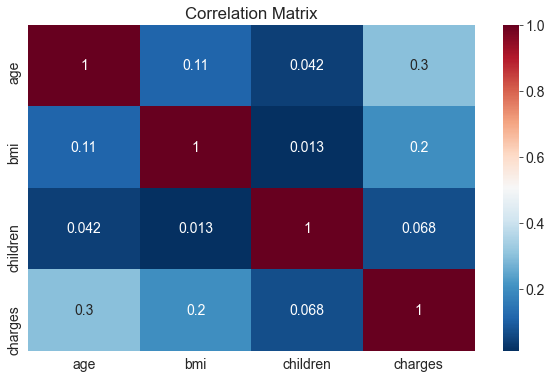

In [18]:
sns.heatmap(medical_df.corr(), cmap='RdBu_r', annot=True)
plt.title('Correlation Matrix');

**Correlation vs causation fallacy:** Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features $X$ and $Y$ can be correlated if $X$ causes $Y$ or if $Y$ causes $X$, or if both are caused independently by some other factor $Z$, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that $X$ are $Y$ simply appear to be correlated because the sample is too small. 

While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

# 3. DATA PREPARATION

In [19]:
# !pip install numpy --quiet

In [20]:
import numpy as np

In [21]:
# !pip install scikit-learn --quiet

## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals




## Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".


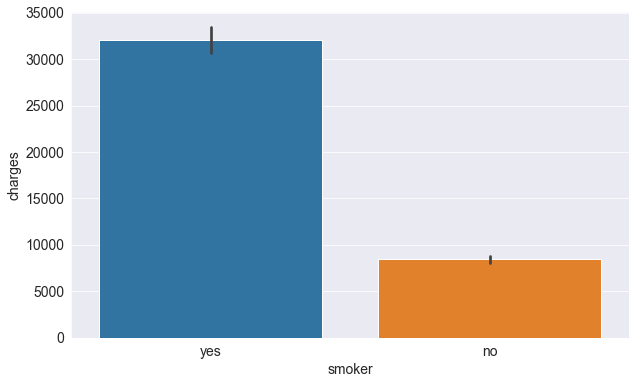

In [22]:
sns.barplot(data=medical_df, x='smoker', y='charges');

In [23]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [24]:
medical_df.charges.corr(medical_df.smoker_code)

0.7872514304984778

In [25]:
medical_df.head()


,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


<AxesSubplot:xlabel='sex', ylabel='charges'>

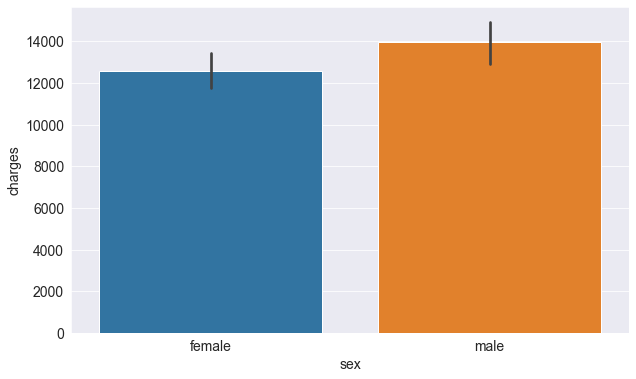

In [26]:
sns.barplot(data=medical_df, x='sex', y='charges')

In [27]:
sex_codes = {'female': 0, 'male': 1}

In [28]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [29]:
medical_df.charges.corr(medical_df.sex_code)

0.05729206220202533

As you might expect, this does have a significant impact on the loss.


### One-hot Encoding

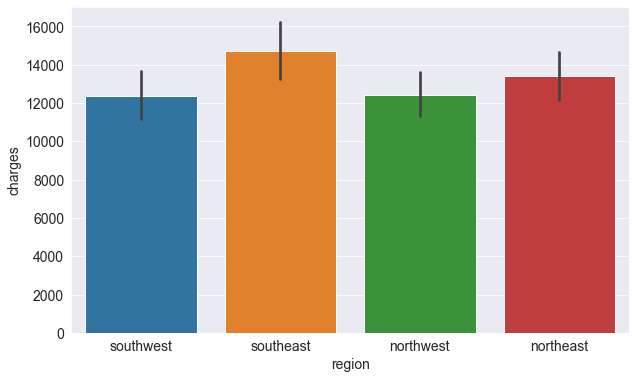

In [30]:
sns.barplot(data=medical_df, x='region', y='charges');

In [31]:
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [32]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [33]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [34]:
medical_df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


<AxesSubplot:>

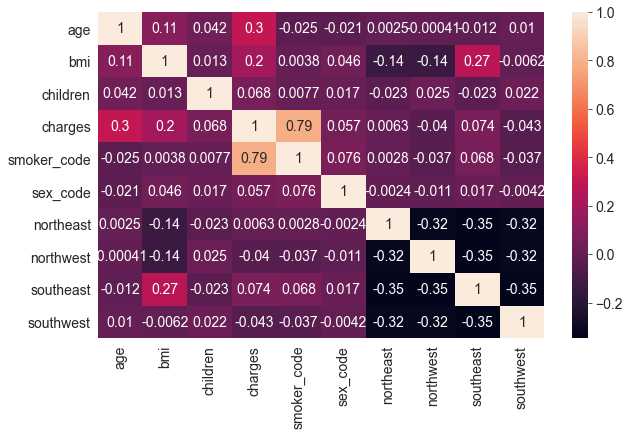

In [35]:
sns.heatmap(medical_df.corr(), annot=True)


## Feature Scaling



The important feature are:

1. Smoker
2. Age
3. BMI


# EXTRACTING THE FEATURES THATS REQUIRED FOR THE MODEL

In [36]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

## Standardization 

* Standardized the numerical data
* Encoded the categorical data
* Concatenate the both standardized-numerical and encoded-categorical data to make a single dataset for training and testing.  

In [37]:
numerical_data = medical_df[['age','bmi','children']]
numerical_data = sc.fit_transform(numerical_data)
categorical_data = medical_df[['smoker_code','sex_code']]
input_data = np.concatenate((numerical_data,categorical_data),axis=1)
input_data

array([[-1.43876426, -0.45332   , -0.90861367,  1.        ,  0.        ],
       [-1.50996545,  0.5096211 , -0.07876719,  0.        ,  1.        ],
       [-0.79795355,  0.38330685,  1.58092576,  0.        ,  1.        ],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367,  0.        ,  0.        ],
       [-1.29636188, -0.79781341, -0.90861367,  0.        ,  0.        ],
       [ 1.55168573, -0.26138796, -0.90861367,  1.        ,  0.        ]])

In [38]:
# targeted value 
output_data = medical_df['charges']

# 4.  MODELS TRAINING AND TESTING 

## Creating a Test Set


In [39]:
from sklearn.model_selection import train_test_split

In [40]:
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = 1)

In [41]:
print(x_train.shape)
len(y_train.shape)

(1070, 5)


1

In [42]:
# pip install tensorflow --quiet

In [43]:
# sc.transform([[33,22.705,0]])

In [44]:
# pred = model.predict([[-0.4419476 , -1.30553108, -0.90861367,0,1]])
# print(pred)

In [45]:
from tensorflow import keras
from keras.models import Sequential

In [46]:
model = Sequential([
        keras.layers.Dense(128, activation = "relu",input_shape=(5,),use_bias=True),
        keras.layers.Dense(64 , activation='relu'),
        keras.layers.Dense(32 , activation='relu'),
        keras.layers.Dense(1)
    ])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.optimizers import Adam
adam = Adam(0.001)
model.compile(optimizer=adam,loss="mean_squared_error")

In [49]:
model.fit(x_train , y_train , epochs=300, validation_data=(x_test,y_test))

Epoch 1/300
34/34 [==============================] - 5s 13ms/step - loss: 320838848.0000 - val_loss: 329532288.0000
Epoch 2/300
34/34 [==============================] - 0s 3ms/step - loss: 320411392.0000 - val_loss: 328477376.0000
Epoch 3/300
34/34 [==============================] - 0s 2ms/step - loss: 317902816.0000 - val_loss: 323336160.0000
Epoch 4/300
34/34 [==============================] - 0s 3ms/step - loss: 308683488.0000 - val_loss: 306942816.0000
Epoch 5/300
34/34 [==============================] - 0s 3ms/step - loss: 283761696.0000 - val_loss: 269550592.0000
Epoch 6/300
34/34 [==============================] - 0s 3ms/step - loss: 235733840.0000 - val_loss: 208035408.0000
Epoch 7/300
34/34 [==============================] - 0s 2ms/step - loss: 171053968.0000 - val_loss: 138864176.0000
Epoch 8/300
34/34 [==============================] - 0s 2ms/step - loss: 116552448.0000 - val_loss: 97455136.0000
Epoch 9/300
34/34 [==============================] - 0s 3ms/step - loss: 9245748

## SOME CONCLUSION FROM THE ABOVE MODEL

* On using optimizes other than Adam the loss was ranging from -inf to +inf 
* This is because of **exploding gradient** 
* On using Adam optimizer it shows a finite loss
* So tuning the hyperparameter is essential to minimized the loss.  


In [50]:
# medical_df.head()

In [51]:
# pred = model.predict(sc.transform([[18,33.770,1,0,1]]))
# pred
# print(minMax.inverse_transform(pred))

# 5.  FINE TUNING

In [52]:
#pip install keras-tuner --quiet

In [53]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras_tuner.tuners import RandomSearch 


## Hyperparameters
- How many number of hidden layers we should have?
- How many number of neurons we should have in hidden layers?
- Learning Rate

In [54]:
# from keras import backend as K
# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [55]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss= hp.Choice('loss' , ['mean_absolute_error','mean_squared_error']),
    metrics= hp.Choice('metrics' , ['mean_absolute_error','mean_squared_error']))
    return model

In [56]:
tuner  = RandomSearch(
    build_model,
    objective=['val_mean_absolute_error','val_mean_squared_error'],
    max_trials=5,
    executions_per_trial=3,
    directory='Hyperparameter_tuning',
    project_name='Insurance estimator'
)

In [57]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
loss (Choice)
{'default': 'mean_absolute_error', 'conditions': [], 'values': ['mean_absolute_error', 'mean_squared_error'], 'ordered': False}
metrics (Choice)
{'default': 'mean_absolute_error', 'conditions': [], 'values': ['mean_absolute_error', 'mean_squared_error'], 'ordered': False}


In [58]:
# tuner.results_summary()

In [60]:
tuner.search(x_train , y_train , epochs=500 , validation_data = (x_test , y_test))

Trial 5 Complete [00h 46m 19s]
multi_objective: 1412.4488525390625

Best multi_objective So Far: 1403.7354736328125
Total elapsed time: 04h 18m 50s
INFO:tensorflow:Oracle triggered exit


In [63]:
tuner.results_summary()

Results summary
Results in Hyperparameter_tuning\Insurance estimator
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 3
units_0: 480
units_1: 384
learning_rate: 0.01
loss: mean_absolute_error
metrics: mean_absolute_error
units_2: 416
units_3: 416
units_4: 64
units_5: 288
units_6: 64
units_7: 480
units_8: 448
Score: 1403.7354736328125
Trial summary
Hyperparameters:
num_layers: 19
units_0: 416
units_1: 224
learning_rate: 0.0001
loss: mean_absolute_error
metrics: mean_absolute_error
units_2: 192
units_3: 320
units_4: 128
units_5: 384
units_6: 480
units_7: 224
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
units_17: 32
units_18: 32
Score: 1412.4488525390625
Trial summary
Hyperparameters:
num_layers: 6
units_0: 224
units_1: 320
learning_rate: 0.0001
loss: mean_absolute_error
metrics: mean_absolute_error
units_2: 352
units_3: 384
units_4: 256
units_5: 480
units_6: 256
units_7: 416
units_8: 320
Score: 1425.95

In [67]:
model = Sequential([
        keras.layers.Dense(480, activation = "relu",input_shape=(5,)),
        keras.layers.Dense(384 , activation='relu'),
        keras.layers.Dense(416 , activation='relu'),
        keras.layers.Dense(416 , activation='relu'),
        keras.layers.Dense(64 , activation='relu'),
        keras.layers.Dense(288 , activation='relu'),
        keras.layers.Dense(64 , activation='relu'),
        keras.layers.Dense(480 , activation='relu'),
        keras.layers.Dense(448 , activation='relu'),
        keras.layers.Dense(1,activation='linear')
    ])
    

In [68]:
from tensorflow.keras.optimizers import Adam
adam = Adam(0.01)
model.compile(optimizer=adam,loss="mean_absolute_error")

In [70]:
model.fit(x_train , y_train , epochs=1000, validation_data=(x_test,y_test))

Epoch 1/1000
34/34 [==============================] - 0s 13ms/step - loss: 1584.9186 - val_loss: 1465.8962
Epoch 2/1000
34/34 [==============================] - 1s 18ms/step - loss: 1618.6838 - val_loss: 1528.7863
Epoch 3/1000
34/34 [==============================] - 0s 13ms/step - loss: 1585.8016 - val_loss: 1721.3615
Epoch 4/1000
34/34 [==============================] - 0s 11ms/step - loss: 1711.0870 - val_loss: 1499.9373
Epoch 5/1000
34/34 [==============================] - 0s 14ms/step - loss: 1524.8307 - val_loss: 1556.1547
Epoch 6/1000
34/34 [==============================] - 1s 16ms/step - loss: 1652.5383 - val_loss: 1742.9608
Epoch 7/1000
34/34 [==============================] - 1s 17ms/step - loss: 1706.3934 - val_loss: 1437.9918
Epoch 8/1000
34/34 [==============================] - 1s 17ms/step - loss: 1584.1376 - val_loss: 1519.2087
Epoch 9/1000
34/34 [==============================] - 1s 15ms/step - loss: 1720.6973 - val_loss: 1773.1290
Epoch 10/1000
34/34 [================

In [71]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0


In [72]:
numerical_col = medical_df[['age','bmi','children']]
numerical_col_std = sc.transform(numerical_col)
cat_data =  medical_df[['smoker_code','sex_code']]
test = np.concatenate((numerical_col_std,cat_data),axis=1)

In [79]:
pred = model.predict([[test]])
count=0
limit = 1000
total_test_size = len(test)
for i in range(len(test)):
    if(abs(pred[i]-medical_df['charges'][i]) > limit):
        count = count + 1
print("Out of ",total_test_size , "data points " ,count , "has difference of above",limit,".")
print(((total_test_size-count)*100)/total_test_size , "%")

Out of  1338 data points  128 has difference of above 1000 .
90.43348281016442 %


# 6. SAVING THE MODEL

In [80]:
model.save("Model.h5")

In [92]:
# !pip install tensorflowjs

In [93]:
# !tensorflowjs_converter --input_format keras \'Model.h5' \ '/Model'

# 7.  CONCLUSION